### Imports

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [2]:
# %pip install -r ../requirements.txt

In [3]:
import cProfile
import pstats

In [4]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.tools.utils import supprimer_fichier_feather_recursif
from src.location import Location
import src.features as ft

In [5]:
import logging
import datetime as dt
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

### Config

In [7]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [8]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

##### Encoding Pipeline

In [9]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    # 'category': {
    #     'as_category': {
    #         'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
    #         'encoders': [
    #             ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
    #         ]
    #     }
    # },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        # 'as_category': {
        #     'imputers': [de.DateFeatureExtractor(dtype='category')],
        #     'encoders': [
        #         ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
        #     ]
        # }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [10]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [11]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x79c3cf523580>),
                                ('pipe...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x79c3cf5b0d60>),
                                ('pipeline-3',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x79c3cf5b1c60>)],
                  verbose=True)

##### Dataset

In [12]:
data_start = '01-01-2019'
data_stop = '31-12-2023'

In [13]:
# Get the list of available hospitals from the names of the files in hospital_feature data folder
available_hospitals = [Location(name=f.removeprefix("export_").removesuffix('.csv')) for f in os.listdir("../data/features/hospitalfeatures/urgences/exports")]

In [14]:
# import datetime as dt
# hospit_path = "../data/features/hospitalfeatures"
# trully_available_hospitals = []
# start_date = dt.datetime.strptime(data_start,'%d-%m-%Y')
# end_date = dt.datetime.strptime(data_stop,'%d-%m-%Y')
# for hospital in available_hospitals:
#     files = [f"hospitalisations/non-programé/urgences/exports/rpu_hospit_total_{hospital}.csv",
#              f"hospitalisations/non-programé/urgences/exports"]
#     file = 
#     df = pd.read_csv(os.path.join(hospit_path, file), sep=";")
#     df.rename(columns={"date_entree": "date"}, inplace=True)
#     if df["date"].dtype != "datetime64[ns]":
#         df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
#     try:
#         date_mask = (df['date'] >= start_date) & (df['date'] <= end_date)
#         df = df[date_mask]
#     except KeyError:
#         print(f"Date range not found in dataset")
#     # print(hospital)
#     # print(len(df.value_counts("Total")))
#     # Si la colonne Total est constante sur l'ensemble des jours, on supprime l'hopital de la liste des hopitaux disponibles
#     if len(df.value_counts("Total")) <= 2:
#         print(f"Hospital {hospital} is not available")
#     else:
#         trully_available_hospitals.append(hospital)


In [15]:
# available_hospitals = trully_available_hospitals

In [16]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": data_start,
    "data_stop": data_stop,
    'data_dir': root_dir / 'data',
    "locations": available_hospitals
    }

In [17]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures,
    # ft.AirQualityFeatures,
    # ft.EpidemiologicalFeatures,
    # # ft.FireFightersFeatures(include_calls=False),
    # # ft.GoogleTrendFeatures,
    # ft.MeteorologicalFeatures,
    # ft.SociologicalFeatures,
    # ft.SportsCompetitionFeatures,
    # ft.TrafficFeatures
    ]

In [18]:

dossiers_a_parcourir = [
    "../data/features"
]

# supprimer_fichier_feather_recursif(dossiers_a_parcourir)

In [19]:
dataset_config = {
    'from_date': data_start,
    'to_date': data_stop,
    'locations': None,
    # 'locations': ['CHU Dijon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon'],
    # 'axis': 'rows',
    # 'shift': range(1, 8, 1),
    # 'rolling_window': [7, 14, 31, 365],
    'freq': '1D',
    'split_config': {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False},
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': ['hospital_nb_emergencies'], #'hospital_nb_hospit_np_from_ED_children', 'hospital_nb_hospit_np_from_ED_adults'
    'targets_shift': -3,
    'targets_rolling_window': 3,
    'targets_history_shifts': range(1, 8, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': None,
    'drop_constant_thr': np.inf,
    'data_dir': root_dir / 'data'
}

In [20]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
profiler = cProfile.Profile()
profiler.enable()
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config)
profiler.disable()

root 2024-12-16 11:29:10,754: INFO: Initialisation de la classe BaseTabularDataset
root 2024-12-16 11:29:10,758: INFO: Initialisation des features
root 2024-12-16 11:29:10,759: INFO: Fetching dataset
root 2024-12-16 11:29:10,761: INFO: hospitalfeatures's data already fetched for CHIC DE HAUTE-COMTÉ


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,66,0,15
2019-01-02,86,0,22
2019-01-03,83,0,23
2019-01-04,63,0,12
2019-01-05,79,0,13
...,...,...,...
2023-12-27,84,0,17
2023-12-28,76,0,14
2023-12-29,93,0,22


root 2024-12-16 11:29:10,776: INFO: hospitalfeatures's data already fetched for HOSPICES CIVILS DE BEAUNE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,54,0,10
2019-01-02,64,0,10
2019-01-03,54,0,10
2019-01-04,61,0,10
2019-01-05,60,0,10
...,...,...,...
2023-12-27,55,0,17
2023-12-28,57,0,14
2023-12-29,68,0,17


root 2024-12-16 11:29:10,785: INFO: hospitalfeatures's data already fetched for CHU DIJON BOURGOGNE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,202,7,46
2019-01-02,198,12,50
2019-01-03,186,11,44
2019-01-04,186,9,49
2019-01-05,204,15,41
...,...,...,...
2023-12-27,165,9,36
2023-12-28,192,17,46
2023-12-29,157,12,44


root 2024-12-16 11:29:10,793: INFO: hospitalfeatures's data already fetched for CHIC AMBOISE- CHATEAU RENAULT


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,46,0,10
2019-01-02,62,0,21
2019-01-03,57,0,14
2019-01-04,59,0,22
2019-01-05,41,0,10
...,...,...,...
2023-12-27,47,0,46
2023-12-28,44,0,41
2023-12-29,44,0,43


root 2024-12-16 11:29:10,802: INFO: hospitalfeatures's data already fetched for CH WILLIAM MOREY CHALON SUR SAONE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,183,8,17
2019-01-02,175,4,31
2019-01-03,164,10,26
2019-01-04,156,2,23
2019-01-05,186,6,17
...,...,...,...
2023-12-27,171,5,28
2023-12-28,163,7,27
2023-12-29,179,11,25


root 2024-12-16 11:29:10,810: INFO: hospitalfeatures's data already fetched for CH JEAN BOUVERI - GALUZOT


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,55,0,18
2019-01-02,57,0,12
2019-01-03,61,0,15
2019-01-04,67,0,13
2019-01-05,53,0,10
...,...,...,...
2023-12-27,53,0,14
2023-12-28,59,0,16
2023-12-29,65,0,10


root 2024-12-16 11:29:10,818: INFO: hospitalfeatures's data already fetched for CHR ORLEANS


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,315,0,67
2019-01-02,371,0,97
2019-01-03,327,0,75
2019-01-04,326,0,80
2019-01-05,307,0,60
...,...,...,...
2023-12-27,292,9,48
2023-12-28,288,8,40
2023-12-29,151,4,10


root 2024-12-16 11:29:10,826: INFO: hospitalfeatures's data already fetched for CH AGGLOMERATION MONTARGOISE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,202,0,10
2019-01-02,264,0,10
2019-01-03,248,0,10
2019-01-04,207,0,10
2019-01-05,184,0,10
...,...,...,...
2023-12-27,237,0,26
2023-12-28,192,0,23
2023-12-29,216,0,22


root 2024-12-16 11:29:10,834: INFO: hospitalfeatures's data already fetched for CH DE NOGENT LE ROTROU


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,40,0,10
2019-01-02,48,0,12
2019-01-03,49,0,14
2019-01-04,40,0,10
2019-01-05,44,0,10
...,...,...,...
2023-12-27,59,0,10
2023-12-28,51,0,10
2023-12-29,52,0,10


root 2024-12-16 11:29:10,841: INFO: hospitalfeatures's data already fetched for HÔPITAL NORD FRANCHE COMTE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,203,0,10
2019-01-02,213,0,36
2019-01-03,228,0,33
2019-01-04,233,0,39
2019-01-05,215,0,36
...,...,...,...
2023-12-27,330,8,44
2023-12-28,280,7,38
2023-12-29,282,5,36


root 2024-12-16 11:29:10,850: INFO: hospitalfeatures's data already fetched for CH VENDOME


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,49,0,10
2019-01-02,64,0,14
2019-01-03,68,0,15
2019-01-04,68,0,14
2019-01-05,70,0,10
...,...,...,...
2023-12-27,57,0,10
2023-12-28,68,0,10
2023-12-29,74,0,10


root 2024-12-16 11:29:10,858: INFO: hospitalfeatures's data already fetched for CH DE LA HAUTE COTE-D'OR - CH-HCO


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,25,0,10
2019-01-02,32,0,10
2019-01-03,39,0,10
2019-01-04,35,0,13
2019-01-05,30,0,10
...,...,...,...
2023-12-27,41,0,14
2023-12-28,44,0,16
2023-12-29,38,0,10


root 2024-12-16 11:29:10,867: INFO: hospitalfeatures's data already fetched for CH J. COEUR BOURGES


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,89,0,10
2019-01-02,90,0,10
2019-01-03,99,0,10
2019-01-04,118,0,10
2019-01-05,97,0,10
...,...,...,...
2023-12-27,161,0,33
2023-12-28,149,0,30
2023-12-29,147,0,27


root 2024-12-16 11:29:10,876: INFO: hospitalfeatures's data already fetched for CH DECIZE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,33,0,10
2019-01-02,29,0,10
2019-01-03,28,0,10
2019-01-04,24,0,10
2019-01-05,23,0,10
...,...,...,...
2023-12-27,36,0,10
2023-12-28,30,0,10
2023-12-29,27,0,10


root 2024-12-16 11:29:10,884: INFO: hospitalfeatures's data already fetched for CH DU VAL DE SAÔNE GRAY


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,22,0,10
2019-01-02,31,0,10
2019-01-03,21,0,10
2019-01-04,23,0,10
2019-01-05,25,0,10
...,...,...,...
2023-12-27,10,0,10
2023-12-28,10,0,10
2023-12-29,10,0,10


root 2024-12-16 11:29:10,892: INFO: hospitalfeatures's data already fetched for CH D'AVALLON


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,30,0,10
2019-01-02,37,0,10
2019-01-03,39,0,10
2019-01-04,34,0,10
2019-01-05,33,0,10
...,...,...,...
2023-12-27,48,0,10
2023-12-28,43,0,10
2023-12-29,49,0,10


root 2024-12-16 11:29:10,900: INFO: hospitalfeatures's data already fetched for HÔPITAL PRIVÉ D'EURE ET LOIR


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,47,0,10
2019-01-02,110,0,10
2019-01-03,81,0,10
2019-01-04,70,0,10
2019-01-05,74,0,10
...,...,...,...
2023-12-27,94,0,10
2023-12-28,90,0,10
2023-12-29,95,0,10


root 2024-12-16 11:29:10,908: INFO: hospitalfeatures's data already fetched for GROUPEMENT HOSPITALIER DE HAUTE SAONE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,141,0,32
2019-01-02,157,0,55
2019-01-03,127,0,40
2019-01-04,119,0,42
2019-01-05,123,0,45
...,...,...,...
2023-12-27,155,0,40
2023-12-28,126,0,37
2023-12-29,149,0,39


root 2024-12-16 11:29:10,917: INFO: hospitalfeatures's data already fetched for CH DE GIEN


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,56,0,14
2019-01-02,106,0,18
2019-01-03,96,0,26
2019-01-04,93,0,19
2019-01-05,68,0,19
...,...,...,...
2023-12-27,115,0,27
2023-12-28,85,0,10
2023-12-29,87,0,18


root 2024-12-16 11:29:10,930: INFO: hospitalfeatures's data already fetched for HÔPITAL PRIVÉ DIJON BOURGOGNE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,72,0,30
2019-01-02,76,0,30
2019-01-03,83,0,34
2019-01-04,69,0,23
2019-01-05,78,0,30
...,...,...,...
2023-12-27,107,0,10
2023-12-28,102,0,13
2023-12-29,105,0,10


root 2024-12-16 11:29:10,948: INFO: hospitalfeatures's data already fetched for CH SENS


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,123,4,23
2019-01-02,132,5,20
2019-01-03,129,5,13
2019-01-04,119,2,24
2019-01-05,122,2,22
...,...,...,...
2023-12-27,174,0,23
2023-12-28,137,1,19
2023-12-29,161,4,22


root 2024-12-16 11:29:10,962: INFO: hospitalfeatures's data already fetched for ORELIANCE - REINE BLANCHE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,52,0,10
2019-01-02,106,0,10
2019-01-03,99,0,10
2019-01-04,85,0,10
2019-01-05,68,0,10
...,...,...,...
2023-12-27,122,0,10
2023-12-28,115,0,10
2023-12-29,101,0,10


root 2024-12-16 11:29:10,973: INFO: hospitalfeatures's data already fetched for SAS NOUVELLE CLINIQUE DE TOURS +


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,50,0,10
2019-01-02,79,0,10
2019-01-03,66,0,10
2019-01-04,67,0,10
2019-01-05,64,0,10
...,...,...,...
2023-12-27,72,0,12
2023-12-28,78,0,10
2023-12-29,79,0,10


root 2024-12-16 11:29:10,982: INFO: hospitalfeatures's data already fetched for CH CHARTRES


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,168,0,39
2019-01-02,248,0,55
2019-01-03,198,0,50
2019-01-04,227,0,39
2019-01-05,174,0,42
...,...,...,...
2023-12-27,200,0,27
2023-12-28,196,0,28
2023-12-29,204,0,36


root 2024-12-16 11:29:10,991: INFO: hospitalfeatures's data already fetched for CH DE CHATEAUDUN


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,43,0,16
2019-01-02,49,0,15
2019-01-03,45,0,10
2019-01-04,32,0,10
2019-01-05,47,0,10
...,...,...,...
2023-12-27,54,0,10
2023-12-28,51,0,10
2023-12-29,44,0,10


root 2024-12-16 11:29:11,004: INFO: hospitalfeatures's data already fetched for CH ROBERT MORLEVAT SEMUR EN AUXOIS


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,39,0,10
2019-01-02,69,0,20
2019-01-03,66,0,22
2019-01-04,62,0,16
2019-01-05,47,0,10
...,...,...,...
2023-12-27,88,0,20
2023-12-28,101,0,28
2023-12-29,97,0,15


root 2024-12-16 11:29:11,016: INFO: hospitalfeatures's data already fetched for CH LA TOUR BLANCHE ISSOUDUN


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,39,0,10
2019-01-02,51,0,16
2019-01-03,34,0,10
2019-01-04,40,0,10
2019-01-05,43,0,10
...,...,...,...
2023-12-27,51,0,10
2023-12-28,39,0,10
2023-12-29,42,0,10


root 2024-12-16 11:29:11,023: INFO: hospitalfeatures's data already fetched for CH LOCHES


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,37,0,10
2019-01-02,58,0,10
2019-01-03,43,0,10
2019-01-04,39,0,10
2019-01-05,34,0,10
...,...,...,...
2023-12-27,42,0,10
2023-12-28,44,0,10
2023-12-29,55,0,10


root 2024-12-16 11:29:11,032: INFO: hospitalfeatures's data already fetched for CH DE PITHIVIERS


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,37,0,10
2019-01-02,47,0,10
2019-01-03,40,0,10
2019-01-04,31,0,10
2019-01-05,47,0,10
...,...,...,...
2023-12-27,44,0,10
2023-12-28,50,0,10
2023-12-29,45,0,10


root 2024-12-16 11:29:11,040: INFO: hospitalfeatures's data already fetched for CH COSNE COURS SUR LOIRE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,41,0,10
2019-01-02,36,0,10
2019-01-03,27,0,10
2019-01-04,32,0,10
2019-01-05,42,0,10
...,...,...,...
2023-12-27,39,0,10
2023-12-28,39,0,10
2023-12-29,37,0,10


root 2024-12-16 11:29:11,051: INFO: hospitalfeatures's data already fetched for CH CHINONAIS


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,44,0,10
2019-01-02,53,0,10
2019-01-03,43,0,10
2019-01-04,51,0,10
2019-01-05,37,0,10
...,...,...,...
2023-12-27,38,0,10
2023-12-28,38,0,10
2023-12-29,44,0,10


root 2024-12-16 11:29:11,059: INFO: hospitalfeatures's data already fetched for CH VICTOR JOUSSELIN


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,115,0,15
2019-01-02,148,0,20
2019-01-03,139,0,21
2019-01-04,133,0,27
2019-01-05,109,0,20
...,...,...,...
2023-12-27,212,0,16
2023-12-28,208,0,22
2023-12-29,234,0,20


root 2024-12-16 11:29:11,074: INFO: hospitalfeatures's data already fetched for CH VIERZON


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,62,0,14
2019-01-02,69,0,22
2019-01-03,74,0,22
2019-01-04,62,0,12
2019-01-05,67,0,24
...,...,...,...
2023-12-27,76,0,10
2023-12-28,67,0,10
2023-12-29,66,0,17


root 2024-12-16 11:29:11,091: INFO: hospitalfeatures's data already fetched for CH LEON BERARD MOREZ


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,10,0,10
2019-01-02,10,0,10
2019-01-03,10,0,10
2019-01-04,10,0,10
2019-01-05,10,0,10
...,...,...,...
2023-12-27,15,0,10
2023-12-28,21,0,10
2023-12-29,10,0,10


root 2024-12-16 11:29:11,102: INFO: hospitalfeatures's data already fetched for CH LOUIS JAILLON SAINT CLAUDE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,28,0,10
2019-01-02,30,0,10
2019-01-03,23,0,10
2019-01-04,31,0,10
2019-01-05,18,0,10
...,...,...,...
2023-12-27,39,0,10
2023-12-28,51,0,10
2023-12-29,36,0,10


root 2024-12-16 11:29:11,111: INFO: hospitalfeatures's data already fetched for CH DU TONNERROIS


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,24,0,10
2019-01-02,39,0,10
2019-01-03,39,0,10
2019-01-04,28,0,10
2019-01-05,27,0,10
...,...,...,...
2023-12-27,61,0,10
2023-12-28,51,0,10
2023-12-29,37,0,10


root 2024-12-16 11:29:11,119: INFO: hospitalfeatures's data already fetched for POLYCLINIQUE STE MARGUERITE AUXERRE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,10,0,10
2019-01-02,10,0,10
2019-01-03,10,0,10
2019-01-04,10,0,10
2019-01-05,10,0,10
...,...,...,...
2023-12-27,10,0,10
2023-12-28,10,0,10
2023-12-29,10,0,10


root 2024-12-16 11:29:11,128: INFO: hospitalfeatures's data already fetched for CH DE JOIGNY


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,48,0,10
2019-01-02,66,0,12
2019-01-03,51,0,10
2019-01-04,44,0,10
2019-01-05,49,0,10
...,...,...,...
2023-12-27,68,0,10
2023-12-28,58,0,10
2023-12-29,53,0,10


root 2024-12-16 11:29:11,136: INFO: hospitalfeatures's data already fetched for CHU DE TOURS


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,280,18,65
2019-01-02,275,13,84
2019-01-03,288,15,63
2019-01-04,256,10,63
2019-01-05,237,10,51
...,...,...,...
2023-12-27,263,14,58
2023-12-28,269,15,55
2023-12-29,251,19,52


root 2024-12-16 11:29:11,143: INFO: hospitalfeatures's data already fetched for CH DE L'AGGLOMÉRATION DE NEVERS


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,112,5,15
2019-01-02,126,2,23
2019-01-03,111,1,19
2019-01-04,138,1,21
2019-01-05,97,2,10
...,...,...,...
2023-12-27,150,7,34
2023-12-28,138,2,37
2023-12-29,153,2,38


root 2024-12-16 11:29:11,151: INFO: hospitalfeatures's data already fetched for CH ROMORANTIN LANTHENAY


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,67,0,13
2019-01-02,74,0,15
2019-01-03,65,0,21
2019-01-04,60,0,19
2019-01-05,62,0,16
...,...,...,...
2023-12-27,74,0,17
2023-12-28,78,0,17
2023-12-29,80,0,12


root 2024-12-16 11:29:11,160: INFO: hospitalfeatures's data already fetched for CH DE CLAMECY


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,30,0,10
2019-01-02,32,0,10
2019-01-03,27,0,10
2019-01-04,18,0,10
2019-01-05,41,0,10
...,...,...,...
2023-12-27,33,0,10
2023-12-28,29,0,10
2023-12-29,31,0,10


root 2024-12-16 11:29:11,168: INFO: hospitalfeatures's data already fetched for CHU BESANCON


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,186,12,33
2019-01-02,228,21,50
2019-01-03,183,13,38
2019-01-04,212,19,39
2019-01-05,188,19,37
...,...,...,...
2023-12-27,181,10,28
2023-12-28,201,9,33
2023-12-29,218,15,33


root 2024-12-16 11:29:11,176: INFO: hospitalfeatures's data already fetched for HOTEL-DIEU DU CREUSOT


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,72,0,12
2019-01-02,106,0,18
2019-01-03,92,0,28
2019-01-04,90,0,16
2019-01-05,113,0,22
...,...,...,...
2023-12-27,115,0,37
2023-12-28,93,0,25
2023-12-29,93,0,21


root 2024-12-16 11:29:11,184: INFO: hospitalfeatures's data already fetched for CH DU PAYS CHAROLAIS BRIONNAIS


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,71,0,15
2019-01-02,98,0,25
2019-01-03,66,0,12
2019-01-04,79,0,16
2019-01-05,64,0,16
...,...,...,...
2023-12-27,74,0,17
2023-12-28,90,0,20
2023-12-29,88,0,33


root 2024-12-16 11:29:11,192: INFO: hospitalfeatures's data already fetched for CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,10,0,10
2019-01-02,10,0,10
2019-01-03,10,0,10
2019-01-04,10,0,10
2019-01-05,10,0,10
...,...,...,...
2023-12-27,10,0,10
2023-12-28,10,0,10
2023-12-29,10,0,10


root 2024-12-16 11:29:11,201: INFO: hospitalfeatures's data already fetched for CH L PASTEUR DOLE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,87,0,10
2019-01-02,74,0,26
2019-01-03,67,0,24
2019-01-04,59,0,19
2019-01-05,82,0,26
...,...,...,...
2023-12-27,100,0,17
2023-12-28,94,0,17
2023-12-29,103,0,20


root 2024-12-16 11:29:11,210: INFO: hospitalfeatures's data already fetched for CH AUXERRE


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,139,5,24
2019-01-02,171,5,27
2019-01-03,149,7,30
2019-01-04,147,6,33
2019-01-05,136,7,25
...,...,...,...
2023-12-27,217,5,28
2023-12-28,181,5,22
2023-12-29,174,3,29


root 2024-12-16 11:29:11,222: INFO: hospitalfeatures's data already fetched for CH LES CHANAUX MACON


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,132,3,33
2019-01-02,161,4,37
2019-01-03,133,7,35
2019-01-04,137,5,33
2019-01-05,126,2,26
...,...,...,...
2023-12-27,168,6,42
2023-12-28,167,5,38
2023-12-29,158,4,42


root 2024-12-16 11:29:11,231: INFO: hospitalfeatures's data already fetched for CH DE CHATEAUROUX


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,134,0,33
2019-01-02,206,0,40
2019-01-03,191,0,42
2019-01-04,160,0,29
2019-01-05,156,0,40
...,...,...,...
2023-12-27,149,0,37
2023-12-28,124,0,29
2023-12-29,133,0,37


root 2024-12-16 11:29:11,241: INFO: hospitalfeatures's data already fetched for CH AUTUN


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,43,0,10
2019-01-02,47,0,10
2019-01-03,39,0,10
2019-01-04,40,0,15
2019-01-05,41,0,10
...,...,...,...
2023-12-27,30,0,10
2023-12-28,27,0,10
2023-12-29,34,0,15


root 2024-12-16 11:29:11,259: INFO: hospitalfeatures's data already fetched for PÔLE SANTÉ LÉONARD DE VINCI


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,49,0,10
2019-01-02,76,0,12
2019-01-03,65,0,10
2019-01-04,64,0,10
2019-01-05,66,0,10
...,...,...,...
2023-12-27,59,0,10
2023-12-28,77,0,12
2023-12-29,53,0,10


root 2024-12-16 11:29:11,279: INFO: hospitalfeatures's data already fetched for CH DE BLOIS


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,148,0,10
2019-01-02,145,0,10
2019-01-03,165,0,10
2019-01-04,138,0,10
2019-01-05,151,0,10
...,...,...,...
2023-12-27,144,0,29
2023-12-28,164,0,22
2023-12-29,151,0,24


root 2024-12-16 11:29:11,288: INFO: hospitalfeatures's data already fetched for CH LE BLANC


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,10,0,10
2019-01-02,10,0,10
2019-01-03,10,0,10
2019-01-04,10,0,10
2019-01-05,10,0,10
...,...,...,...
2023-12-27,10,0,10
2023-12-28,10,0,10
2023-12-29,10,0,10


root 2024-12-16 11:29:11,299: INFO: hospitalfeatures's data already fetched for CH ST AMAND MONTROND


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,40,0,10
2019-01-02,44,0,10
2019-01-03,34,0,10
2019-01-04,39,0,10
2019-01-05,44,0,10
...,...,...,...
2023-12-27,51,0,16
2023-12-28,55,0,12
2023-12-29,17,0,10


root 2024-12-16 11:29:11,309: INFO: hospitalfeatures's data already fetched for CH JURA SUD


,hospital_nb_emergencies,hospital_nb_hospit_np_from_ED_children,hospital_nb_hospit_np_from_ED_adults
date,,,
2019-01-01,124,0,10
2019-01-02,127,0,10
2019-01-03,119,2,10
2019-01-04,106,0,10
2019-01-05,124,0,10
...,...,...,...
2023-12-27,133,0,30
2023-12-28,108,0,20
2023-12-29,118,2,29


In [21]:
# Afficher les résultats
stats = pstats.Stats(profiler)
stats.sort_stats('cumulative').print_stats()  # Afficher les fonctions les plus consommatrices de temps

         768927 function calls (756815 primitive calls) in 0.564 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.564    0.282 /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517(run_code)
      8/2    0.000    0.000    0.564    0.282 {built-in method builtins.exec}
        1    0.000    0.000    0.564    0.564 /tmp/ipykernel_42949/3666784505.py:1(<module>)
        1    0.000    0.000    0.564    0.564 /home/maxime/Documents/WORKSPACES/forecasting_models/src/datasets/base_tabular_dataset.py:57(__init__)
        1    0.001    0.001    0.559    0.559 /home/maxime/Documents/WORKSPACES/forecasting_models/src/datasets/base_tabular_dataset.py:143(fetch_dataset)
       56    0.003    0.000    0.553    0.010 /home/maxime/Documents/WORKSPACES/forecasting_models/src/features/base_features.py:212(wrapper)
       56    0.001    0

In [22]:
# supprimer_fichier_feather_recursif([fetch_config['data_dir'] / f'datasets/'], 'full_dataset', extension='.csv')

In [23]:
profiler = cProfile.Profile()
profiler.enable()
for location in fetch_config['locations']:
    # Define the configuration of the dataset
    dataset_config.update(locations=[location])
    dataset_config.update(targets_locations=[location])

    arsTabularDataset.get_dataset(**dataset_config)

    df = arsTabularDataset.enc_data

    # Identifie les colonnes contenant des NaN
    cols_with_nan = df.columns[df.isna().any()].tolist()
    print("Colonnes contenant des NaN:", cols_with_nan)

    # Affiche la liste des index des lignes contenant des NaN pour chaque colonne
    nan_indices = {col: df[df[col].isna()].index.tolist() for col in cols_with_nan}
    print(nan_indices)

    # df.to_csv(fetch_config['data_dir'] / f'datasets/full_dataset_{location.name}.csv')
    df.to_csv(fetch_config['data_dir'] / f'datasets/target_history_dataset_{location.name}_{arsTabularDataset.targets_names[0]}.csv')
    df_target = arsTabularDataset.data[arsTabularDataset.targets_names]
    # df_target.to_csv(fetch_config['data_dir'] / f'datasets/full_dataset_{location.name}_targets_hospits.csv')

profiler.disable()


root 2024-12-16 11:29:11,463: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CHIC DE HAUTE-COMTÉ
root 2024-12-16 11:29:11,465: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:11,474: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:11,475: INFO: Creating target history columns...
root 2024-12-16 11:29:11,476: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:11,477: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                    

Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)


root 2024-12-16 11:29:11,602: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:11,673: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for HOSPICES CIVILS DE BEAUNE
root 2024-12-16 11:29:11,675: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:11,683: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:11,684: INFO: Creating target history columns...
root 2024-12-16 11:29:11,684: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:11,685: WARNING: 2 as target history shift is not high enough considering                                

[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.1s
Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:11,700: INFO: Calculating train/val/test sets...
root 2024-12-16 11:29:11,747: INFO: 17 features not encoded (same unit as target)


Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:11,815: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CHU DIJON BOURGOGNE
root 2024-12-16 11:29:11,816: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:11,824: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:11,825: INFO: Creating target history columns...
root 2024-12-16 11:29:11,826: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:11,827: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                    

Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:11,958: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CHIC AMBOISE- CHATEAU RENAULT
root 2024-12-16 11:29:11,959: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:11,969: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:11,970: INFO: Creating target history columns...
root 2024-12-16 11:29:11,971: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:11,972: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,          

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:12,044: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:12,111: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH WILLIAM MOREY CHALON SUR SAONE
root 2024-12-16 11:29:12,112: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:12,120: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:12,121: INFO: Creating target history columns...
root 2024-12-16 11:29:12,122: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:12,123: WARNING: 2 as target history shift is not high enough considering                        

Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:12,137: INFO: Calculating train/val/test sets...
root 2024-12-16 11:29:12,183: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:12,252: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH JEAN BOUVERI - GALUZOT
root 2024-12-16 11:29:12,253: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:12,261: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:12,263: INFO: Creating target history columns...
root 2024-12-16 11:29:12,263: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:12,264: WARNING: 2 as target histo

Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:12,325: INFO: 17 features not encoded (same unit as target)


Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:12,393: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CHR ORLEANS
root 2024-12-16 11:29:12,394: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:12,402: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:12,403: INFO: Creating target history columns...
root 2024-12-16 11:29:12,404: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:12,405: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                            

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:12,535: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH AGGLOMERATION MONTARGOISE
root 2024-12-16 11:29:12,536: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:12,544: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:12,546: INFO: Creating target history columns...
root 2024-12-16 11:29:12,546: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:12,547: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,           

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:12,610: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:12,677: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DE NOGENT LE ROTROU
root 2024-12-16 11:29:12,678: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:12,686: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:12,688: INFO: Creating target history columns...
root 2024-12-16 11:29:12,688: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:12,689: WARNING: 2 as target history shift is not high enough considering                                   

Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:12,751: INFO: 17 features not encoded (same unit as target)


Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:12,821: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for HÔPITAL NORD FRANCHE COMTE
root 2024-12-16 11:29:12,822: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:12,830: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:12,831: INFO: Creating target history columns...
root 2024-12-16 11:29:12,832: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:12,833: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,             

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:12,972: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH VENDOME
root 2024-12-16 11:29:12,974: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:12,985: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:12,986: INFO: Creating target history columns...
root 2024-12-16 11:29:12,986: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:12,987: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                             

Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:13,002: INFO: Calculating train/val/test sets...
root 2024-12-16 11:29:13,049: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:13,115: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DE LA HAUTE COTE-D'OR - CH-HCO
root 2024-12-16 11:29:13,116: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:13,124: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:13,125: INFO: Creating target history columns...
root 2024-12-16 11:29:13,126: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:13,126: WARNING: 2 as targ

Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:13,141: INFO: Calculating train/val/test sets...
root 2024-12-16 11:29:13,187: INFO: 17 features not encoded (same unit as target)


Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:13,255: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH J. COEUR BOURGES
root 2024-12-16 11:29:13,256: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:13,263: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:13,265: INFO: Creating target history columns...
root 2024-12-16 11:29:13,265: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:13,266: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                    

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:13,395: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DECIZE
root 2024-12-16 11:29:13,397: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:13,405: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:13,406: INFO: Creating target history columns...
root 2024-12-16 11:29:13,407: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:13,408: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                              

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:13,468: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:13,535: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DU VAL DE SAÔNE GRAY
root 2024-12-16 11:29:13,536: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:13,544: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:13,546: INFO: Creating target history columns...
root 2024-12-16 11:29:13,546: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:13,547: WARNING: 2 as target history shift is not high enough considering                                  

Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:13,607: INFO: 17 features not encoded (same unit as target)


Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:13,669: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH D'AVALLON
root 2024-12-16 11:29:13,670: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:13,678: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:13,679: INFO: Creating target history columns...
root 2024-12-16 11:29:13,680: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:13,681: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                           

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:13,808: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for HÔPITAL PRIVÉ D'EURE ET LOIR
root 2024-12-16 11:29:13,809: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:13,818: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:13,820: INFO: Creating target history columns...
root 2024-12-16 11:29:13,820: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:13,821: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,           

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:13,884: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:13,952: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for GROUPEMENT HOSPITALIER DE HAUTE SAONE
root 2024-12-16 11:29:13,953: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:13,962: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:13,963: INFO: Creating target history columns...
root 2024-12-16 11:29:13,964: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:13,965: WARNING: 2 as target history shift is not high enough considering                    

Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:14,026: INFO: 17 features not encoded (same unit as target)


Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:14,094: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DE GIEN
root 2024-12-16 11:29:14,095: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:14,104: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:14,105: INFO: Creating target history columns...
root 2024-12-16 11:29:14,106: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:14,107: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                             

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:14,242: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for HÔPITAL PRIVÉ DIJON BOURGOGNE
root 2024-12-16 11:29:14,243: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:14,252: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:14,254: INFO: Creating target history columns...
root 2024-12-16 11:29:14,255: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:14,256: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,          

Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:14,272: INFO: Calculating train/val/test sets...
root 2024-12-16 11:29:14,319: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:14,387: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH SENS
root 2024-12-16 11:29:14,389: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:14,398: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:14,399: INFO: Creating target history columns...
root 2024-12-16 11:29:14,400: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:14,401: WARNING: 2 as target history shift is not hi

Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:14,422: INFO: Calculating train/val/test sets...
root 2024-12-16 11:29:14,469: INFO: 17 features not encoded (same unit as target)


Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:14,538: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for ORELIANCE - REINE BLANCHE
root 2024-12-16 11:29:14,539: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:14,549: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:14,550: INFO: Creating target history columns...
root 2024-12-16 11:29:14,551: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:14,553: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,              

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:14,686: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for SAS NOUVELLE CLINIQUE DE TOURS +
root 2024-12-16 11:29:14,687: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:14,697: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:14,698: INFO: Creating target history columns...
root 2024-12-16 11:29:14,698: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:14,700: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,       

Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:14,719: INFO: Calculating train/val/test sets...
root 2024-12-16 11:29:14,764: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:14,830: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH CHARTRES
root 2024-12-16 11:29:14,832: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:14,840: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:14,842: INFO: Creating target history columns...
root 2024-12-16 11:29:14,842: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:14,844: WARNING: 2 as target history shift is no

Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:14,906: INFO: 17 features not encoded (same unit as target)


Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:14,975: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DE CHATEAUDUN
root 2024-12-16 11:29:14,976: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:14,985: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:14,986: INFO: Creating target history columns...
root 2024-12-16 11:29:14,987: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:14,988: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                       

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)


root 2024-12-16 11:29:15,085: INFO: 17 features not encoded (same unit as target)


[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:15,159: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH ROBERT MORLEVAT SEMUR EN AUXOIS
root 2024-12-16 11:29:15,161: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:15,169: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:15,170: INFO: Creating target history columns...
root 2024-12-16 11:29:15,171: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:15,172: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,     

Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:15,302: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH LA TOUR BLANCHE ISSOUDUN
root 2024-12-16 11:29:15,303: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:15,312: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:15,313: INFO: Creating target history columns...
root 2024-12-16 11:29:15,314: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:15,315: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,            

Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:15,441: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH LOCHES
root 2024-12-16 11:29:15,444: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:15,457: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:15,459: INFO: Creating target history columns...
root 2024-12-16 11:29:15,459: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:15,461: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                              

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:15,596: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DE PITHIVIERS
root 2024-12-16 11:29:15,597: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:15,606: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:15,608: INFO: Creating target history columns...
root 2024-12-16 11:29:15,608: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:15,609: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                       

Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:15,618: INFO: Rolling windows will start from 6 samples before to 7, 14, 31, 365 days before this starting sample
root 2024-12-16 11:29:15,629: INFO: Calculating train/val/test sets...
root 2024-12-16 11:29:15,679: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:15,750: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH COSNE COURS SUR LOIRE
root 2024-12-16 11:29:15,752: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:15,760: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:15,761: INFO: Creating target history columns...
root 2024-12-16 11:29:15,761: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_hist

Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:15,777: INFO: Calculating train/val/test sets...


Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)


root 2024-12-16 11:29:15,840: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:15,914: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH CHINONAIS
root 2024-12-16 11:29:15,916: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:15,924: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:15,925: INFO: Creating target history columns...
root 2024-12-16 11:29:15,926: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:15,927: WARNING: 2 as target history shift is not high enough considering                                             

[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)


root 2024-12-16 11:29:15,989: INFO: 17 features not encoded (same unit as target)


[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:16,095: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH VICTOR JOUSSELIN
root 2024-12-16 11:29:16,096: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:16,104: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:16,106: INFO: Creating target history columns...
root 2024-12-16 11:29:16,106: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:16,107: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                    

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:16,243: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH VIERZON
root 2024-12-16 11:29:16,245: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:16,254: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:16,255: INFO: Creating target history columns...
root 2024-12-16 11:29:16,256: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:16,257: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                             

Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:16,260: WARNING: 5 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 5 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:16,262: INFO: Rolling windows will start from 6 samples before to 7, 14, 31, 365 days before this starting sample
root 2024-12-16 11:29:16,274: INFO: Calculating train/val/test sets...
root 2024-12-16 11:29:16,320: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:16,386: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH LEON BERARD MOREZ
root 2024-12-16 11:29:16,387: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:16,396: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by

Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:16,459: INFO: 17 features not encoded (same unit as target)


Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:16,526: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH LOUIS JAILLON SAINT CLAUDE
root 2024-12-16 11:29:16,528: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:16,536: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:16,537: INFO: Creating target history columns...
root 2024-12-16 11:29:16,537: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:16,538: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,          

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:16,668: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DU TONNERROIS
root 2024-12-16 11:29:16,669: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:16,677: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:16,678: INFO: Creating target history columns...
root 2024-12-16 11:29:16,679: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:16,680: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                       

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:16,741: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:16,808: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for POLYCLINIQUE STE MARGUERITE AUXERRE
root 2024-12-16 11:29:16,810: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:16,818: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:16,819: INFO: Creating target history columns...
root 2024-12-16 11:29:16,820: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:16,821: WARNING: 2 as target history shift is not high enough considering                      

Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:16,884: INFO: 17 features not encoded (same unit as target)


Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:16,949: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DE JOIGNY
root 2024-12-16 11:29:16,951: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:16,959: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:16,961: INFO: Creating target history columns...
root 2024-12-16 11:29:16,961: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:16,963: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                           

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:17,102: INFO: 17 features not encoded (same unit as target)


Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:17,169: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CHU DE TOURS
root 2024-12-16 11:29:17,170: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:17,179: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:17,180: INFO: Creating target history columns...
root 2024-12-16 11:29:17,181: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:17,182: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                           

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:17,310: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DE L'AGGLOMÉRATION DE NEVERS
root 2024-12-16 11:29:17,311: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:17,320: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:17,321: INFO: Creating target history columns...
root 2024-12-16 11:29:17,321: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:17,322: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,        

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:17,383: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:17,451: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH ROMORANTIN LANTHENAY
root 2024-12-16 11:29:17,452: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:17,460: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:17,462: INFO: Creating target history columns...
root 2024-12-16 11:29:17,462: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:17,463: WARNING: 2 as target history shift is not high enough considering                                  

Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:17,523: INFO: 17 features not encoded (same unit as target)


Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:17,591: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DE CLAMECY
root 2024-12-16 11:29:17,592: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:17,601: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:17,603: INFO: Creating target history columns...
root 2024-12-16 11:29:17,603: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:17,604: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                          

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:17,735: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CHU BESANCON
root 2024-12-16 11:29:17,737: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:17,744: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:17,745: INFO: Creating target history columns...
root 2024-12-16 11:29:17,746: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:17,746: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                           

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:17,808: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:17,875: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for HOTEL-DIEU DU CREUSOT
root 2024-12-16 11:29:17,877: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:17,884: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:17,885: INFO: Creating target history columns...
root 2024-12-16 11:29:17,886: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:17,887: WARNING: 2 as target history shift is not high enough considering                                    

Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:17,947: INFO: 17 features not encoded (same unit as target)


Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:18,019: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DU PAYS CHAROLAIS BRIONNAIS
root 2024-12-16 11:29:18,020: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:18,028: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:18,030: INFO: Creating target history columns...
root 2024-12-16 11:29:18,030: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:18,031: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,         

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:18,186: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE
root 2024-12-16 11:29:18,187: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency


Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:18,195: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:18,196: INFO: Creating target history columns...
root 2024-12-16 11:29:18,196: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:18,197: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 2 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:18,198: WARNING: 3 as target history shift is not high enough considering                                 

Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:18,352: INFO: Calculating train/val/test sets...
root 2024-12-16 11:29:18,409: INFO: 17 features not encoded (same unit as target)


Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:18,477: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH AUXERRE
root 2024-12-16 11:29:18,478: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:18,487: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:18,489: INFO: Creating target history columns...
root 2024-12-16 11:29:18,490: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:18,491: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                             

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)


root 2024-12-16 11:29:18,557: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:18,624: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH LES CHANAUX MACON
root 2024-12-16 11:29:18,626: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:18,637: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:18,640: INFO: Creating target history columns...
root 2024-12-16 11:29:18,641: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:18,643: WARNING: 2 as target history shift is not high enough considering                                     

[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:18,650: WARNING: 5 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 5 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:18,655: INFO: Rolling windows will start from 6 samples before to 7, 14, 31, 365 days before this starting sample
root 2024-12-16 11:29:18,671: INFO: Calculating train/val/test sets...
root 2024-12-16 11:29:18,720: INFO: 17 features not encoded (same unit as target)


Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:18,788: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DE CHATEAUROUX
root 2024-12-16 11:29:18,790: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:18,798: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:18,800: INFO: Creating target history columns...
root 2024-12-16 11:29:18,801: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:18,802: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                      

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:18,933: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH AUTUN
root 2024-12-16 11:29:18,935: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:18,943: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:18,945: INFO: Creating target history columns...
root 2024-12-16 11:29:18,945: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:18,946: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                               

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:19,007: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:19,074: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for PÔLE SANTÉ LÉONARD DE VINCI
root 2024-12-16 11:29:19,076: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:19,084: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:19,085: INFO: Creating target history columns...
root 2024-12-16 11:29:19,086: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:19,087: WARNING: 2 as target history shift is not high enough considering                              

Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it


root 2024-12-16 11:29:19,151: INFO: 17 features not encoded (same unit as target)


Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:19,221: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH DE BLOIS
root 2024-12-16 11:29:19,222: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:19,231: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:19,232: INFO: Creating target history columns...
root 2024-12-16 11:29:19,233: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:19,234: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                            

Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s


root 2024-12-16 11:29:19,369: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH LE BLANC
root 2024-12-16 11:29:19,370: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:19,379: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:19,380: INFO: Creating target history columns...
root 2024-12-16 11:29:19,381: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:19,382: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                            

Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:19,397: INFO: Calculating train/val/test sets...
root 2024-12-16 11:29:19,442: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:19,531: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH ST AMAND MONTROND
root 2024-12-16 11:29:19,533: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency


Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}


root 2024-12-16 11:29:19,546: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:19,548: INFO: Creating target history columns...
root 2024-12-16 11:29:19,548: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:19,550: WARNING: 2 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 2 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:19,551: WARNING: 3 as target history shift is not high enough considering                                 

Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)


root 2024-12-16 11:29:19,621: INFO: 17 features not encoded (same unit as target)
root 2024-12-16 11:29:19,689: INFO: Getting the dataset from 01-01-2019 to 31-12-2023 for CH JURA SUD
root 2024-12-16 11:29:19,690: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency
root 2024-12-16 11:29:19,699: INFO: Creating the target columns as a rolling mean of hospital_nb_emergencies on 3 rows shifted by -3
root 2024-12-16 11:29:19,700: INFO: Creating target history columns...
root 2024-12-16 11:29:19,700: WARNING: 1 as target history shift is not high enough considering                                                that the target is shifted and/or is a rolling mean,                                                
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-12-16 11:29:19,701: WARNING: 2 as target history shift is not high enough considering                                              

[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}
Index 'date' not found in the data, creating it
Dropped 0 constant columns from both sets: set()
target_hospital_nb_emergencies%J+3%mean_3J
X shape: (1163, 1), y shape: (1163, 1)
[ColumnTransformer] .... (1 of 1) Processing pipeline-2, total=   0.0s
Colonnes contenant des NaN: []
{}


In [24]:
# Afficher les résultats
stats = pstats.Stats(profiler)
stats.sort_stats('cumulative').print_stats()  # Afficher les fonctions les plus consommatrices de temps

         9370400 function calls (9165042 primitive calls) in 8.366 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    8.370    4.185 /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517(run_code)
      3/2    0.000    0.000    8.370    4.185 {built-in method builtins.exec}
       56    0.005    0.000    6.736    0.120 /home/maxime/Documents/WORKSPACES/forecasting_models/src/datasets/base_tabular_dataset.py:657(get_dataset)
       56    0.007    0.000    4.182    0.075 /home/maxime/Documents/WORKSPACES/forecasting_models/src/datasets/base_tabular_dataset.py:179(encode)
  952/168    0.004    0.000    3.854    0.023 /home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/sklearn/utils/_set_output.py:293(wrapped)
      168    0.002    0.000    3.682    0.022 /home/maxime/Documents/WORKSPACES/for

In [25]:
# found = False
# for location in fetch_config['locations']:
#     df = pd.read_csv(fetch_config['data_dir'] / f'datasets/full_dataset_{location}.csv')
#     cols = df.columns.to_list()
#     assert len(cols) == len(set(cols)), f'Duplicate column names for {location}'
#     print(location)

#     if df.shape[1] != 491:
#         print(df.shape)
#         # Print the columns that are in all_cols but not in cols
#         print(set(all_cols) - set(cols))
#     else:
#         if not found:
#             all_cols = df.columns.to_list()
#             found = True

root 2024-12-16 11:29:20,020: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-31 00:00:00, at a 1D frequency


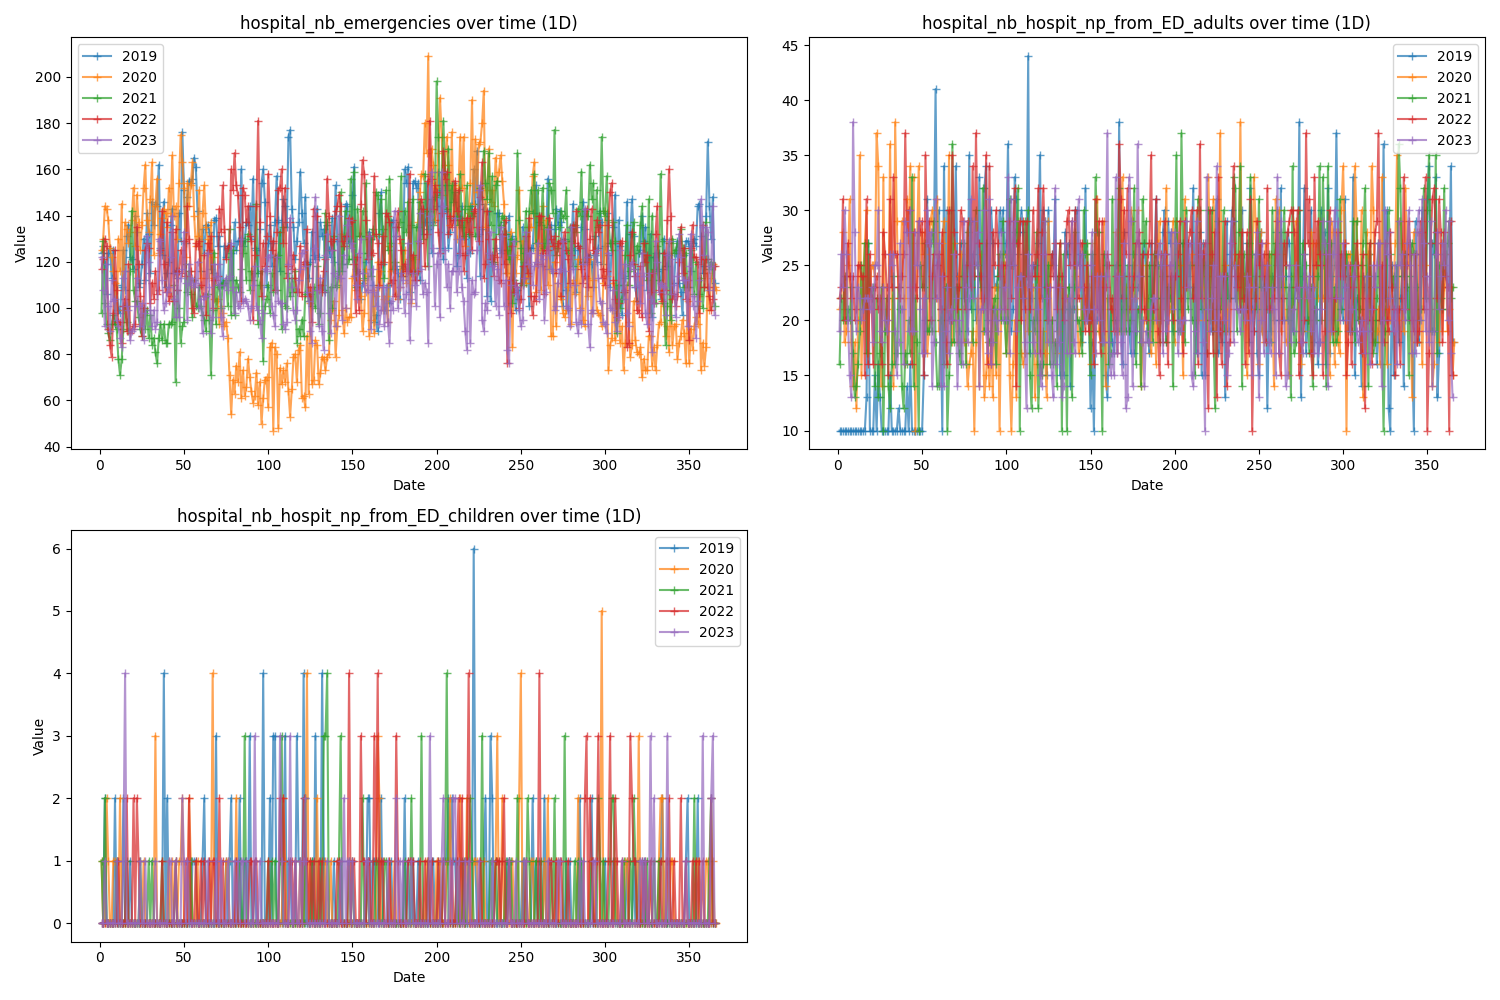

In [26]:
for features in arsTabularDataset.features:
    features.plot(location=location)